In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import scipy.stats as stats
import warnings
import itertools

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn import set_config
from IPython.display import display, HTML

In [2]:
df = pd.read_csv('hmeq.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


In [4]:
def create_scrollable_table(df, table_id, title):
    html = f'<h3>{title}</h3>'
    html += f'<div id= "{table_id}" style= "height: 200px; overflow:auto;">'
    html += df.to_html()
    html += '<\div>'
    return html

In [5]:
df.isna().sum()/len(df)

BAD        0.000000
LOAN       0.000000
MORTDUE    0.086913
VALUE      0.018792
REASON     0.042282
JOB        0.046812
YOJ        0.086409
DEROG      0.118792
DELINQ     0.097315
CLAGE      0.051678
NINQ       0.085570
CLNO       0.037248
DEBTINC    0.212584
dtype: float64

In [6]:
numerical_features = df.select_dtypes(include=np.number)
summary_stats = numerical_features.describe().T
html_numerical = create_scrollable_table(summary_stats, 'Numerical Features', 'Summary stats for numerical features')

display(HTML(html_numerical))

,count,mean,std,min,25%,50%,75%,max
BAD,5960.0,0.199497,0.399656,0.000000,0.000000,0.000000,0.000000,1.000000
LOAN,5960.0,18607.969799,11207.480417,1100.000000,11100.000000,16300.000000,23300.000000,89900.000000
MORTDUE,5442.0,73760.817200,44457.609458,2063.000000,46276.000000,65019.000000,91488.000000,399550.000000
VALUE,5848.0,101776.048741,57385.775334,8000.000000,66075.500000,89235.500000,119824.250000,855909.000000
YOJ,5445.0,8.922268,7.573982,0.000000,3.000000,7.000000,13.000000,41.000000
DEROG,5252.0,0.254570,0.846047,0.000000,0.000000,0.000000,0.000000,10.000000
DELINQ,5380.0,0.449442,1.127266,0.000000,0.000000,0.000000,0.000000,15.000000
CLAGE,5652.0,179.766275,85.810092,0.000000,115.116702,173.466667,231.562278,1168.233561
NINQ,5450.0,1.186055,1.728675,0.000000,0.000000,1.000000,2.000000,17.000000
CLNO,5738.0,21.296096,10.138933,0.000000,15.000000,20.000000,26.000000,71.000000


In [7]:
df.shape

(5960, 13)

In [8]:
categorical_features = df.select_dtypes(include=[object])
cat_summary_stats = categorical_features.describe().T
html_categorical = create_scrollable_table(cat_summary_stats, 'categorical_features', 'Summary Statistics for categorical features')

display(HTML(html_categorical))

,count,unique,top,freq
REASON,5708,2,DebtCon,3928
JOB,5681,6,Other,2388


In [9]:
df.columns

Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG',
       'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC'],
      dtype='object')

In [10]:
mu, sigma = stats.norm.fit(df['LOAN'])

hist_data = go.Histogram(x= df['LOAN'], nbinsx= 75, name= 'Histogram', opacity= .85, histnorm='probability density', marker= dict(color= 'green'))

x_norm = np.linspace(df['LOAN'].min(), df['LOAN'].max(), 100)
y_norm = stats.norm.pdf(x_norm, mu, sigma)

norm_data = go.Scatter(x= x_norm, y= y_norm, mode= 'lines', name= f"Normal Distribution (mu= {mu:.2f}, sigma= {sigma:.2f})", line= dict(color="red"))

fig1= go.Figure(data=[hist_data, norm_data])

skew_value = df['LOAN'].skew()

fig1.update_layout(
    title= f'Loan Distribution with skew value: {skew_value:.2f}',
    xaxis_title= "Loan Amount",
    yaxis_title= "Density",
    legend_title_text= "Fitted Normal Distribution",
    plot_bgcolor= 'rgba(32,32,32,1)',
    paper_bgcolor= 'rgba(32,32,32,1)',
    font= dict(color= 'white')
)

In [11]:
mu, sigma = stats.norm.fit(np.log(df['LOAN']))

hist_data = go.Histogram(x= np.log(df['LOAN']), nbinsx= 75, name= 'Histogram', opacity= .85, histnorm='probability density', marker= dict(color= 'green'))

x_norm = np.linspace(np.log(df['LOAN']).min(), np.log(df['LOAN']).max(), 100)
y_norm = stats.norm.pdf(x_norm, mu, sigma)

norm_data = go.Scatter(x= x_norm, y= y_norm, mode= 'lines', name= f"Normal Distribution (mu= {mu:.2f}, sigma= {sigma:.2f})", line= dict(color="red"))

fig1= go.Figure(data=[hist_data, norm_data])

skew_value = np.log(df['LOAN']).skew()

fig1.update_layout(
    title= f'Loan Distribution with skew value: {skew_value:.2f}',
    xaxis_title= "Loan Amount",
    yaxis_title= "Density",
    legend_title_text= "Fitted Normal Distribution",
    plot_bgcolor= 'rgba(32,32,32,1)',
    paper_bgcolor= 'rgba(32,32,32,1)',
    font= dict(color= 'white')
)

In [12]:
skew_value = df['MORTDUE'].skew()

fig3 = px.histogram(df, x= 'MORTDUE', title= f'Histogram of Mortgage Due with skewness value {skew_value:.2f}')
fig3.show()

In [13]:
skew_value = np.log(df['MORTDUE']).skew()

fig4 = px.histogram(df, x= np.log(df['MORTDUE']), title= f'Histogram of Mortgage Due with skew value: {skew_value:.2f}')
fig4.show()

In [14]:
skew_value = df['VALUE'].skew()

fig5 = px.histogram(df, x= 'VALUE', title= f'Histogram of Value with skewness value {skew_value:.2f}')
fig5.show()

In [15]:
skew_value = np.log(df['VALUE']).skew()

fig6 = px.histogram(df, x= np.log(df['VALUE']), title= f'Histogram of Value with skew value: {skew_value:.2f}')
fig6.show()

In [16]:
skew_value = df['CLAGE'].skew()

fig7 = px.histogram(df, x= 'CLAGE', title= f'Histogram of CLAGE with skewness value {skew_value:.2f}')
fig7.show()

In [17]:
skew_value = np.log(df['CLAGE']).skew()

fig8 = px.histogram(df, x= np.log(df['CLAGE']), title= f'Histogram of CLAGE with skew value: {skew_value:.2f}')
fig8.show()

c:\Users\Jake\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning:

divide by zero encountered in log



In [18]:
skew_value = df['DEBTINC'].skew()

fig9 = px.histogram(df, x= 'DEBTINC', title= f'Histogram of DEBTINC with skewness value {skew_value:.2f}')
fig9.show()

In [19]:
skew_value = np.log(df['DEBTINC']).skew()

fig10 = px.histogram(df, x= np.log(df['DEBTINC']), title= f'Histogram of DEBTINC with skewness value {skew_value:.2f}')
fig10.show()

In [20]:
from scipy.stats.mstats import winsorize

winsorized_debtinc = winsorize(df['DEBTINC'], (0, 0.05))
winsorized_clage = winsorize(df['CLAGE'], (0, 0.05))

# Replace skewed values with log

### Cleaned Numerical Values

In [21]:
df['LOAN'] = np.log(df['LOAN'])
df['MORTDUE'] = np.log(df['MORTDUE'])
df['VALUE'] = np.log(df['VALUE'])

### New Variables

In [22]:
columns = ['DEROG', 'DELINQ']
df = df.dropna(subset= columns, how= 'any')

In [23]:
df['b_delinq'] = (df['DELINQ'] >= 1) * 1
df['b_derog'] = (df['DEROG'] >= 1) * 1

df['b_delinq'] = df['b_delinq'].astype(object)
df['b_derog'] = df['b_derog'].astype(object)

In [24]:
### Correlation Plot
numerical_features = df.select_dtypes(include= np.number)
correlation_matrix = numerical_features.corr()

# Create a heatmap with correlation values using Plotly
fig = px.imshow(correlation_matrix,
                labels=dict(x='Features', y='Features', color='Correlation'),
                x=correlation_matrix.columns,
                y=correlation_matrix.columns,
                color_continuous_scale='Viridis')

# Add Pearson correlation coefficients as text labels
fig.update_traces(text=np.round(correlation_matrix.values, 2), showscale=False)

# Customize the layout
fig.update_layout(title='Correlation Plot with Pearson Correlation Coefficients',
                  xaxis_title='Features',
                  yaxis_title='Features')

# Show the plot
fig.show()

In [25]:
# Define Numerical and Categorical Transformers

numerical_transformer = Pipeline(steps= [
    ('imputer', SimpleImputer(strategy= 'mean')),
    ('scalar', StandardScaler())
])

categorical_transformer = Pipeline(steps= [
    ('imputer', SimpleImputer(strategy= 'constant', fill_value= 'Other')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='if_binary', sparse= False))
])

In [28]:
# Update categorical and numeric columns 

categorical_columns = df.select_dtypes(include=['object', 'category']).columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Remove target variable
numerical_columns = numerical_columns.drop('BAD')

set_config(transform_output="pandas")
# Combine Transformers using Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ], remainder= 'passthrough')

# Create a Pipeline with the preprocessor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)])

# Apply the pipeline to our dataset
X = df.drop('BAD', axis= 1)
y = df['BAD']
X_preprocessed = pipeline.fit_transform(X)

c:\Users\Jake\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



In [29]:
X_preprocessed

,num__LOAN,num__MORTDUE,num__VALUE,num__YOJ,num__DEROG,num__DELINQ,num__CLAGE,num__NINQ,num__CLNO,num__DEBTINC,...,cat__JOB_Mgr,cat__JOB_Office,cat__JOB_Other,cat__JOB_ProfExe,cat__JOB_Sales,cat__JOB_Self,cat__b_delinq_0,cat__b_delinq_1,cat__b_derog_0,cat__b_derog_1
0,-4.655215,-1.350704,-1.714958,0.196483,-0.293638,-0.378545,-1.009201,-0.082934,-1.216278,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,-4.364996,0.218936,-0.575169,-0.274240,-0.293638,1.519681,-0.683260,-0.679663,-0.714385,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,-4.116390,-2.374510,-3.438937,-0.677717,-0.293638,-0.378545,-0.355341,-0.082934,-1.115899,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,-3.898947,0.744492,0.426416,-0.812209,-0.293638,-0.378545,-1.021464,-0.679663,-0.714385,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
5,-3.898947,-1.088295,-1.648653,-0.005256,-0.293638,-0.378545,-0.924955,-0.082934,-1.316656,0.449409,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,2.975255,-0.098566,-0.013592,0.936190,-0.293638,-0.378545,0.503127,-0.679663,-0.513628,0.314230,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
5956,2.977208,-0.174292,0.047460,0.936190,-0.293638,-0.378545,0.347475,-0.679663,-0.614006,0.280158,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
5957,2.981107,-0.189692,0.047176,0.801698,-0.293638,-0.378545,0.390049,-0.679663,-0.614006,0.239199,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
5958,2.992754,-0.300610,0.023808,0.667206,-0.293638,-0.378545,0.409190,-0.679663,-0.513628,0.075070,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size= 0.25, random_state=24)

In [31]:
# Splitting the Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size= 0.25, random_state=24)

# Chosen Models

models = {
    'LogisticRegression' : LogisticRegression(random_state= 24),
    'SVC' : SVC(random_state= 24),
    'RandomForestClassifier' : RandomForestClassifier(random_state= 24),
    'GradientBoostingClassifier' : GradientBoostingClassifier(random_state= 24)
}

# Tune Hyper Parameters

param_grids = {
    'LogisticRegression' : {'solver' : ['newton-cg', 'lbfgs', 'liblinear'],
                            'penalty' : ['l2'],
                            'C' : [100, 10, 1.0, 0.1, 0.01]},
    'SVC' : {'C' : [100, 10, 1.0, 0.1, 0.01],
             'gamma' : [1, 0.1, 0.01, 0.001, 0.0001],
             'kernel' : ['sigmoid', 'rbf', 'linear', 'poly']},
    'RandomForestClassifier' : {'n_estimators' : [100, 500, 1000],
                               'max_features' : ['sqrt', 'log2']},
    'GradientBoostingClassifier' : {'learning_rate' : [0.05, 0.1, 0.15],
                                   'n_estimators' : [100, 500, 1000],
                                   'max_depth' : [3, 7, 9],
                                   'subsample' : [0.7, 1]}
}

cv = KFold(n_splits= 5, shuffle= True, random_state= 24)

grids = {}

for model_name, model in models.items():
    print(f'Training and tuning {model_name}...')
    grids[model_name] = GridSearchCV(estimator= model, param_grid= param_grids[model_name], cv= cv, scoring= 'accuracy', n_jobs= -1, verbose= 2)
    grids[model_name].fit(X_preprocessed, y)
    best_params = grids[model_name].best_params_
    best_score = grids[model_name].best_score_

    print(f'Best parameters for {model_name}: {best_params}')
    print(f'Best Accuracy for {model_name}: {best_score}\n')

Training and tuning LogisticRegression...
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters for LogisticRegression: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Best Accuracy for LogisticRegression: 0.838840579710145

Training and tuning SVC...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters for SVC: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
Best Accuracy for SVC: 0.9555555555555555

Training and tuning RandomForestClassifier...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters for RandomForestClassifier: {'max_features': 'sqrt', 'n_estimators': 500}
Best Accuracy for RandomForestClassifier: 0.9290821256038647

Training and tuning GradientBoostingClassifier...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters for GradientBoostingClassifier: {'learning_rate': 0.15, 'max_depth': 9, 'n_estimators': 1000, 'subsample': 0.7}
Best Accuracy for GradientBoostingClassifier: 0.93913

In [32]:
# LR Confusion Matrix

from sklearn.metrics import confusion_matrix

lr = LogisticRegression(solver= 'newton-cg', penalty= 'l2', C= 100)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap with orange color using Plotly
fig = go.Figure(data=go.Heatmap(z=cm, x=['Predicted 0', 'Predicted 1'], y=['Actual 0', 'Actual 1'], colorscale='YlOrRd'))

# Add actual values as labels
for i, actual_row in enumerate(cm):
    for j, actual_value in enumerate(actual_row):
        fig.add_annotation(
            x='Predicted ' + str(j),
            y='Actual ' + str(i),
            text=str(actual_value),
            showarrow=False,
            font=dict(color='black', size=12)
        )

# Customize the layout
fig.update_layout(title='Logistic Regression Confusion Matrix', xaxis_title='Predicted Label', yaxis_title='Actual Label')

# Show the plot
fig.show()

In [33]:
# SVM Confusion Matrix

svm = SVC(C= 100, gamma= 1, kernel= 'rbf')
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap with orange color using Plotly
fig = go.Figure(data=go.Heatmap(z=cm, x=['Predicted 0', 'Predicted 1'], y=['Actual 0', 'Actual 1'], colorscale='YlOrRd'))

# Add actual values as labels
for i, actual_row in enumerate(cm):
    for j, actual_value in enumerate(actual_row):
        fig.add_annotation(
            x='Predicted ' + str(j),
            y='Actual ' + str(i),
            text=str(actual_value),
            showarrow=False,
            font=dict(color='black', size=12)
        )
        
# Customize the layout
fig.update_layout(title='SVM Confusion Matrix', xaxis_title='Predicted Label', yaxis_title='Actual Label')

# Show the plot
fig.show()

In [34]:
# Random Forest Classifier Confusion Matrix

rfc = RandomForestClassifier(max_features= 'sqrt', n_estimators= 500)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap with orange color using Plotly
fig = go.Figure(data=go.Heatmap(z=cm, x=['Predicted 0', 'Predicted 1'], y=['Actual 0', 'Actual 1'], colorscale='YlOrRd'))

# Add actual values as labels
for i, actual_row in enumerate(cm):
    for j, actual_value in enumerate(actual_row):
        fig.add_annotation(
            x='Predicted ' + str(j),
            y='Actual ' + str(i),
            text=str(actual_value),
            showarrow=False,
            font=dict(color='black', size=12)
        )
        
# Customize the layout
fig.update_layout(title='Random Forest Classifier Confusion Matrix', xaxis_title='Predicted Label', yaxis_title='Actual Label')

# Show the plot
fig.show()

In [35]:
# Gradient Boosting Classifier Confusion Matrix

gbc = GradientBoostingClassifier(learning_rate= 0.1, max_depth= 9, n_estimators= 1000, subsample= 0.7)
gbc.fit(X_train, y_train)

y_pred = gbc.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap with orange color using Plotly
fig = go.Figure(data=go.Heatmap(z=cm, x=['Predicted 0', 'Predicted 1'], y=['Actual 0', 'Actual 1'], colorscale='YlOrRd'))

# Add actual values as labels
for i, actual_row in enumerate(cm):
    for j, actual_value in enumerate(actual_row):
        fig.add_annotation(
            x='Predicted ' + str(j),
            y='Actual ' + str(i),
            text=str(actual_value),
            showarrow=False,
            font=dict(color='black', size=12)
        )

# Customize the layout
fig.update_layout(title='Gradient Boosting Classifier Confusion Matrix', xaxis_title='Predicted Label', yaxis_title='Actual Label')

# Show the plot
fig.show()

<Axes: >

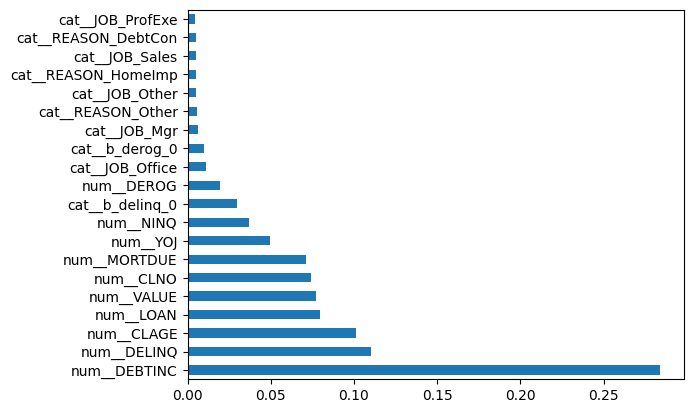

In [36]:
feat_importances = pd.Series(gbc.feature_importances_, index=X_preprocessed.columns)
feat_importances.nlargest(20).plot(kind='barh')